In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, recall_score, \
                            classification_report, roc_auc_score, precision_score, \
                            f1_score, matthews_corrcoef, average_precision_score, \
                            precision_recall_curve, auc, roc_curve
from collections import Counter
%config Completer.use_jedi = False

In [2]:
def calc_stats(y_test, y_pred, X_test, clf):
    probs = clf.predict_proba(X_test)
    prob1 = probs[:, 1]
    stats_s = pd.Series(dtype='float')
    stats_s['recall'] = recall_score(y_test, y_pred)
    stats_s['prec'] = precision_score(y_test, y_pred)
    stats_s['MCC'] = matthews_corrcoef(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, prob1, pos_label=1)
    stats_s['PR_AUC'] = auc(recall, precision)
    stats_s['avg_prec'] = average_precision_score(y_test, prob1)
    stats_s['roc_auc'] = roc_auc_score(y_test, prob1)
    
    return stats_s

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def sample_data(X, y, samp_type, samp_strat, seed=0):
    if samp_type == 'over':
        sampler = RandomOverSampler(sampling_strategy=samp_strat, random_state=seed)
    elif samp_type == 'under':
        sampler = RandomUnderSampler(sampling_strategy=samp_strat, random_state=seed)
    else:
        print("Invalid 'samp_type'")
        
    # fit and apply the transform
    X_res, y_res = sampler.fit_resample(X, y)
    # summarize class distribution
    #print(Counter(y_res))
    #print(X_res.shape)
    
    return X_res, y_res

# Bootstrapped  random statistics runs

In [4]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
def bootstrap_stat(X, y, clf, nsamples=100, sample_weights=False, under=False, samp_strat=1.0):
    stats_df = pd.DataFrame()
    feat_imps_df = pd.DataFrame()
    for seed in range(nsamples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)
        #print(f'In bstrap(): y_train.shape = {y_train.shape}; X_train.shape = {X_train.shape}')
        #print(f'In bstrap(): np.bincount(y_train) = {np.bincount(y_train)}')

        if under:
            # Undersample the training data
            #print('Undersampling')
            X_res, y_res = sample_data(X_train, y_train, "under", samp_strat=samp_strat, seed=seed)
        else:
            #print('No Undersampling')
            X_res, y_res = X_train, y_train # Not subsampled; use with class_weight='balanced' or sample_weights
            
        if sample_weights:
            weights = class_weight.compute_sample_weight('balanced', y=y_res)
            #print(f'np.unique(weights): {np.unique(weights)}')
            clf.fit(X_res, y_res, sample_weight=weights)
        else:
            clf.fit(X_res, y_res)
            
        y_pred = clf.predict(X_test)

        stats_s = calc_stats(y_test, y_pred, X_test, clf)
        if stats_df.empty:
            stats_df = pd.DataFrame(stats_s)
            stats_df = stats_df.T
        else:
            stats_df = stats_df.append(stats_s, ignore_index=True)
            
        if feat_imps_df.empty:
            feat_imps_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
        else:
            temp_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
            feat_imps_df = feat_imps_df.merge(temp_df, left_index=True, right_index=True, how="left")
        
    return stats_df, feat_imps_df, X_res

In [24]:
corr_df = pd.read_csv('../../data/csl/CramerTheil/Cramer_PI_Ty_coeff_ALL.csv', index_col=0, header=None, delimiter='\t')
corr_vars = list(corr_df.index.values)
len(corr_vars)
df = pd.read_csv('../../data/csl/CSL_ty_PI.csv', index_col=0)
X = df.drop('transfus_yes', axis=1, inplace=False)
X = X[corr_vars]
y = df['transfus_yes'].values

['Inoxy_incrdose', 'Intratocolytix', 'Admcontract', 'Education', 'HospElectCS', 'DMControl', 'HosEpiNurse', 'BESTGA', 'Hostype', 'AdmBishop', 'GAmethod', 'Delfetalpos', 'Analgesia', 'AdmSBP', 'Admconsistency', 'Augment', 'Admcervpos', 'Insurance', 'AdmDBP', 'momrace_new', 'Admpresent', 'HospElectInd', 'HxnumCS', 'Episiotomy', 'Ind_Unkn', 'ROMmeth', 'MthInd_AROM', 'Admefface', 'Admreason', 'Marital', 'Dilat_lst', 'Ind_elect', 'Antesteroid', 'Meconium', 'Anteanemia', 'intra_abruptio', 'MthInd_Oxy', 'HosEpitype', 'Operative', 'IntraMgSO', 'high_height', 'FSE', 'intra_previa', 'ThreatenedPB', 'pre_PROM', 'Anteabruption', 'Anteprevia', 'Delmode', 'Parity', 'Induction', 'GestHBP', 'Antethyroid', 'Antehospital', 'Preeclampsia', 'ROM', 'Presentdel', 'Anteasthma', 'Ind_HTN', 'high_BMI', 'IUPC', 'Antebleed3', 'Accrete', 'high_Age', 'CS_Elect', 'PostHBP', 'vertex', 'TrialLabor', 'Antefetdistress', 'gest_diab', 'breech', 'MthInd_PGE2', 'AnteSGA', 'Malpresentation9', 'Alcohol', 'Intrafetdistress', 

In [25]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
                                     min_samples_split=900,max_leaf_nodes=None,max_features=12,subsample=0.9,
                                     learning_rate=0.1,random_state=7)
#clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
#                                     min_samples_split=900,max_leaf_nodes=None,max_features=None,subsample=0.9,
#                                     learning_rate=0.1,random_state=7)
#stats_df = bootstrap_stat(X, y, clf, nsamples=100, under=True)
stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, nsamples=10, under=True)
#stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, sample_weights=True, nsamples=10, under=False)
stats_df.loc['mean'] = stats_df.mean()
stats_df.loc['mean',:]

CPU times: user 18 s, sys: 2.96 s, total: 21 s
Wall time: 21.2 s


recall      0.880529
prec        0.090274
MCC         0.231618
PR_AUC      0.118842
avg_prec    0.119293
roc_auc     0.865668
Name: mean, dtype: float64

In [26]:
feats_df['mean'] = feats_df.mean(axis=1)
feats_df.sort_values(by='mean', inplace=True, ascending=False)
pd.options.display.max_rows = 150
print(feats_df.loc['DMControl'])
print(feats_df.loc['Inoxy_incrdose'])

0       0.072248
1       0.062187
2       0.114502
3       0.088270
4       0.127340
5       0.089390
6       0.094177
7       0.089675
8       0.052874
9       0.089510
mean    0.088017
Name: DMControl, dtype: float64
0       0.120207
1       0.102621
2       0.089106
3       0.130151
4       0.099810
5       0.083513
6       0.116849
7       0.090958
8       0.132511
9       0.102257
mean    0.106798
Name: Inoxy_incrdose, dtype: float64


In [27]:
%%time
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

CPU times: user 2.46 s, sys: 15.3 ms, total: 2.47 s
Wall time: 2.44 s


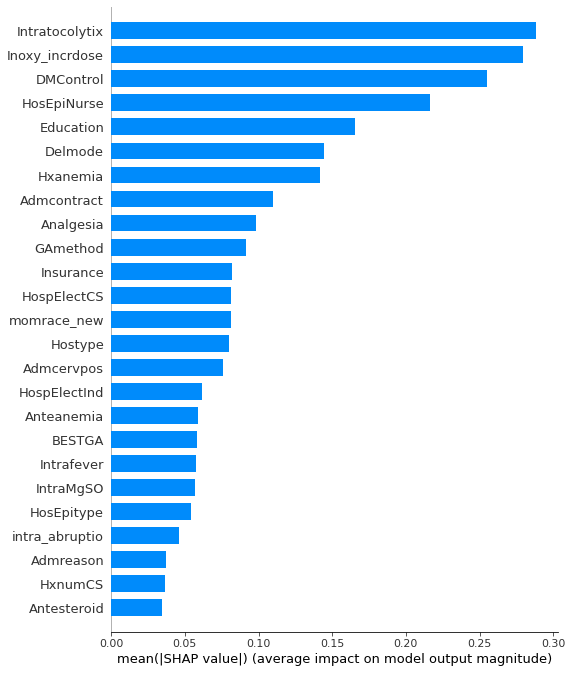

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=25)

invalid value encountered in true_divide
invalid value encountered in true_divide


           Variable  SHAP_abs      Corr  Sign
32      Antesteroid  0.034226  0.910204   red
22          HxnumCS  0.036308 -0.945453  blue
28        Admreason  0.037203  0.854181   red
35   intra_abruptio  0.046270  0.989619   red
37       HosEpitype  0.054405 -0.857781  blue
39        IntraMgSO  0.056978  0.982919   red
87       Intrafever  0.057340  0.972710   red
7            BESTGA  0.057948 -0.779505  blue
34       Anteanemia  0.059051  0.985395   red
21     HospElectInd  0.061574 -0.686832  blue
16       Admcervpos  0.076062 -0.894386  blue
8           Hostype  0.080064  0.749780   red
19      momrace_new  0.081333 -0.678461  blue
4       HospElectCS  0.081552 -0.458830  blue
17        Insurance  0.081960 -0.874399  blue
10         GAmethod  0.091200  0.835059   red
12        Analgesia  0.098457 -0.922864  blue
2       Admcontract  0.109725 -0.748884  blue
172        Hxanemia  0.141524  0.981139   red
47          Delmode  0.144588  0.939159   red
3         Education  0.165718 -0.8

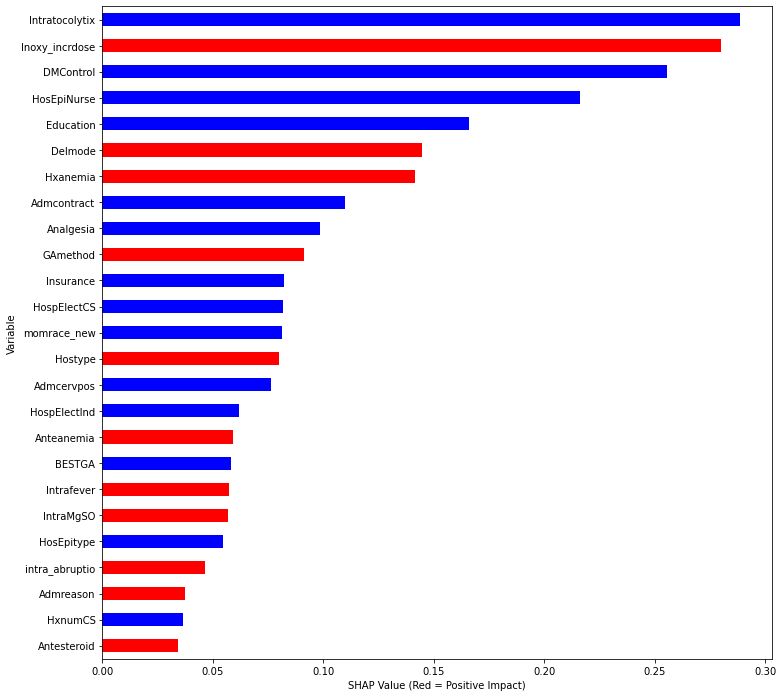

In [29]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2.tail(25)['Sign']
    print(k2.tail(25))
    ax = k2.tail(25).plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,12),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

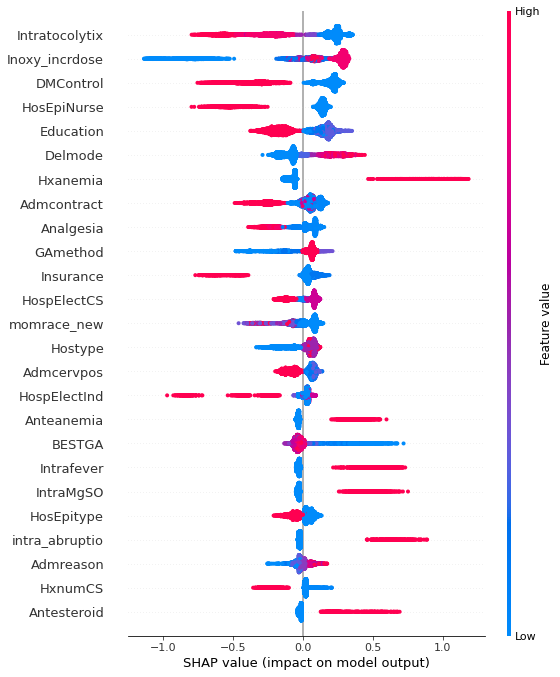

CPU times: user 1.72 s, sys: 35.7 ms, total: 1.75 s
Wall time: 1.77 s


In [30]:
%%time
shap.summary_plot(shap_values, X_train, max_display=25)

In [31]:
shap.initjs()
print(X_train.shape)

(7238, 192)


In [32]:
#shap.plots.scatter(shap_values['Lac_Min'])
shap_values

array([[ 0.06161931, -0.26911664, -0.25454108, ...,  0.        ,
         0.        ,  0.        ],
       [-0.67134868, -0.42107248,  0.05194382, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11545043, -0.1417956 ,  0.0624988 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01880098,  0.07719831, -0.02043848, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32339624,  0.27117711,  0.15721813, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14101656, -0.14432464,  0.08083483, ...,  0.        ,
         0.        ,  0.        ]])

In [33]:
#print(X_train.iloc[500])
#shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[500])
#print(X_train.shape)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


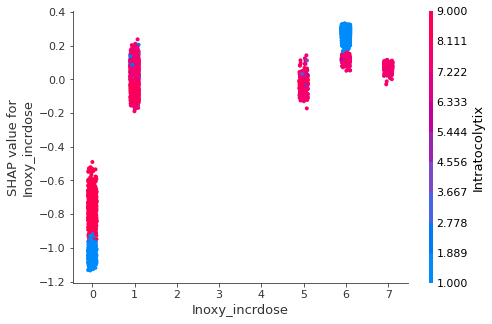

In [34]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


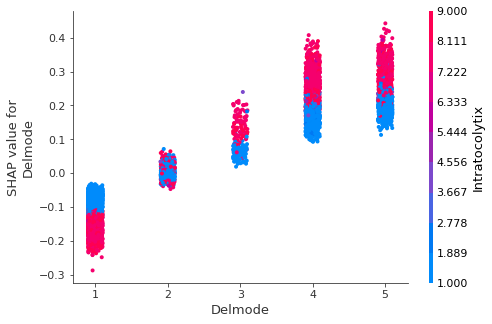

In [35]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


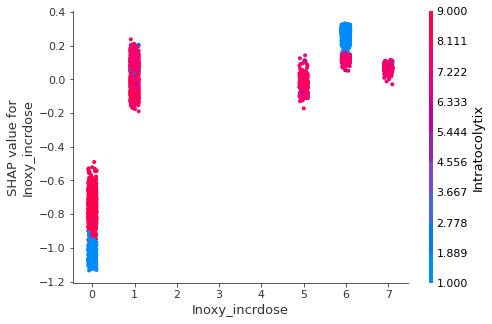

In [37]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


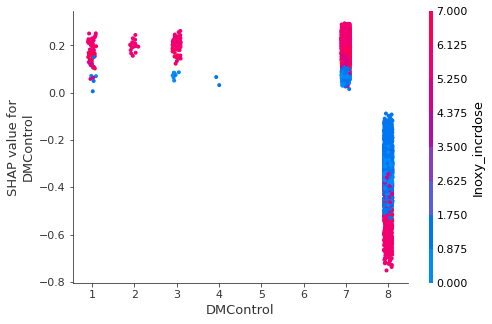

In [38]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


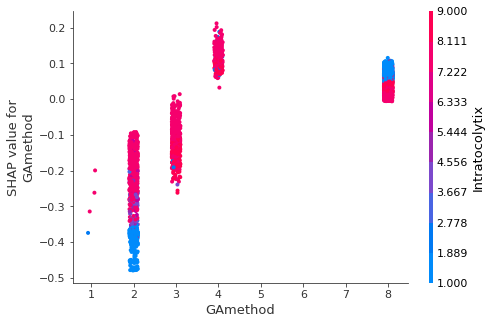

In [39]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


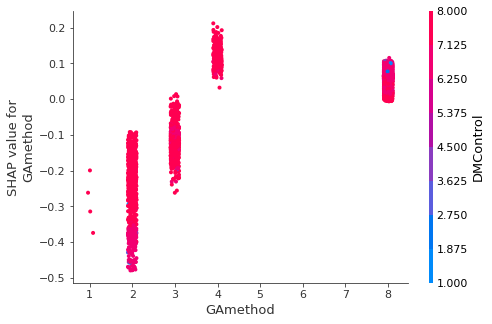

In [40]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2, interaction_index='DMControl')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


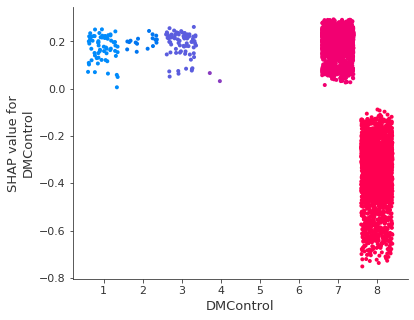

In [41]:
#shap.dependence_plot("DMControl", shap_values, X_train, interaction_index='DMControl')
#shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2, interaction_index='DMControl')
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.8, interaction_index='DMControl')

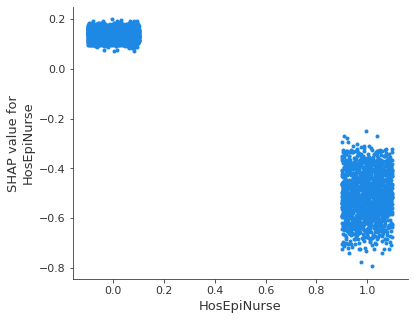

In [42]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2, interaction_index=None)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


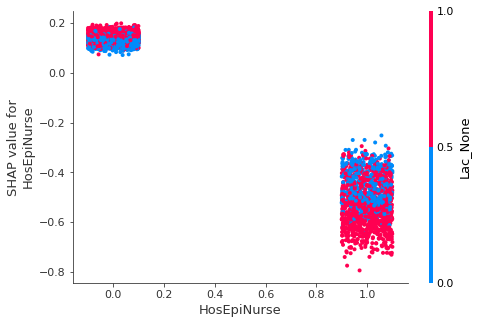

In [43]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


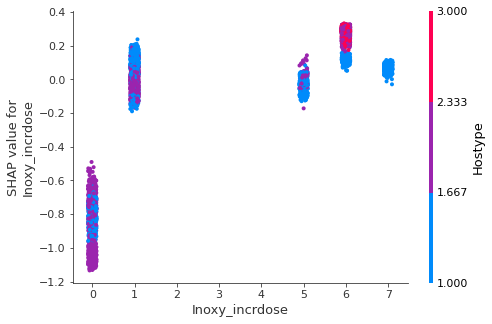

In [44]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Hostype')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


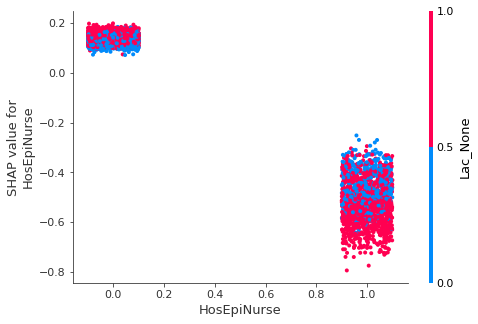

In [45]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


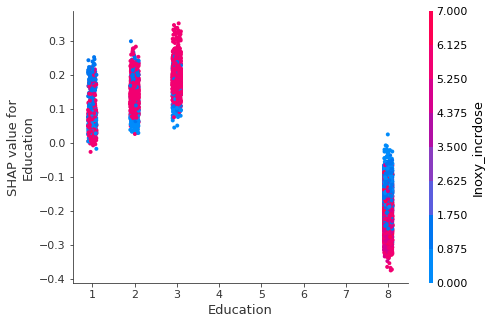

In [46]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


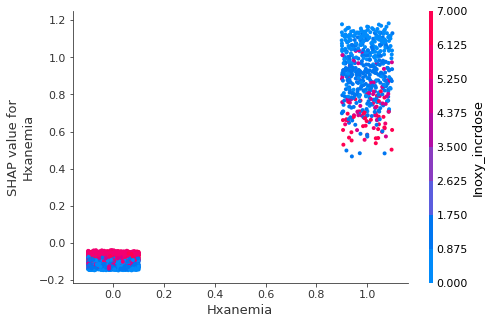

In [47]:
shap.dependence_plot("Hxanemia", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


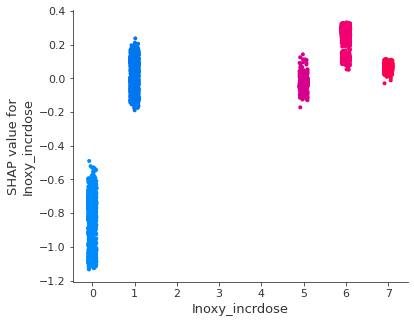

In [48]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Inoxy_incrdose')

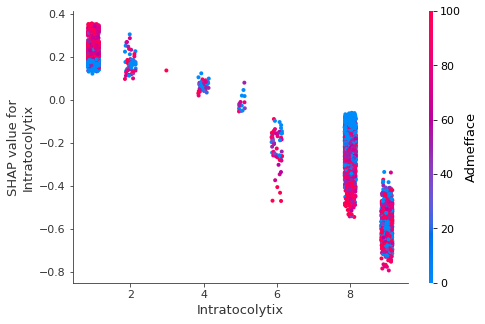

In [49]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.3)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


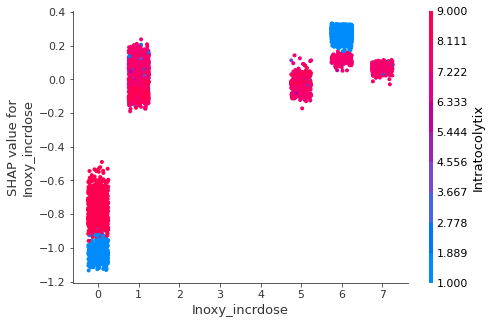

In [50]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.5)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


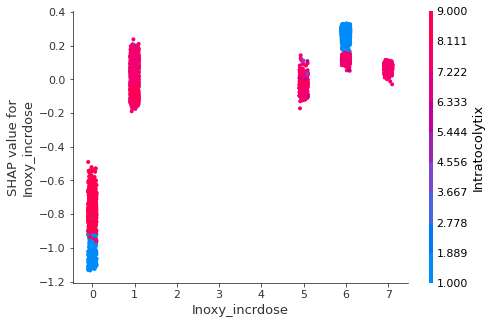

In [51]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

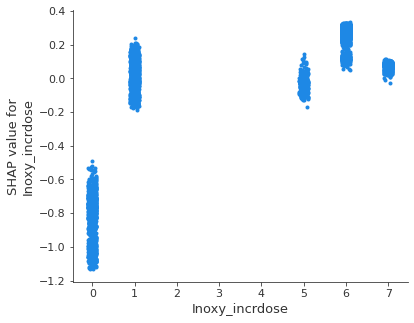

In [52]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index=None)

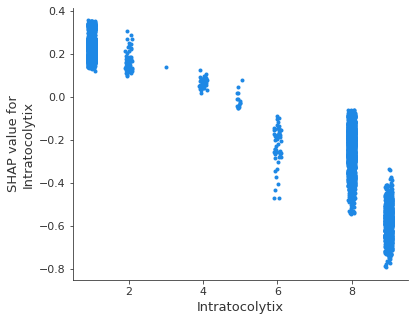

In [53]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.2, interaction_index=None)

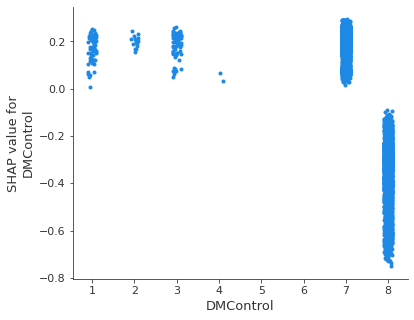

In [54]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2, interaction_index=None)

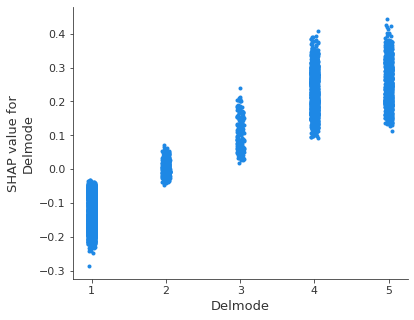

In [55]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.1, interaction_index=None)

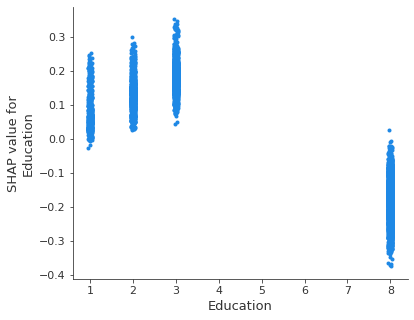

In [56]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.1, interaction_index=None)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


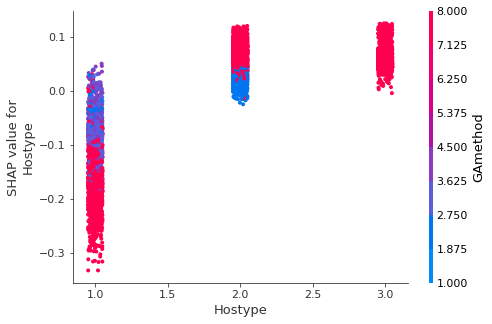

In [57]:
shap.dependence_plot("Hostype", shap_values, X_train, x_jitter=0.1)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


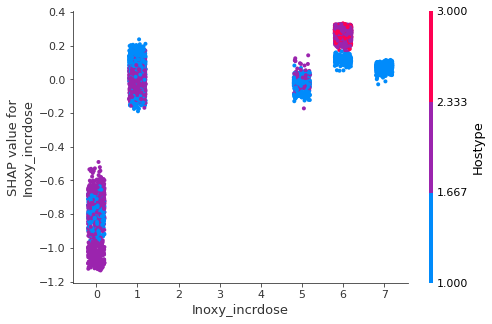

In [58]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hostype')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


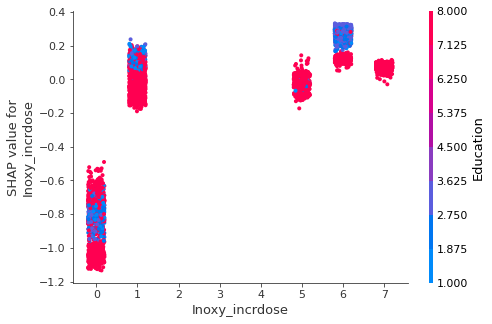

In [59]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Education')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


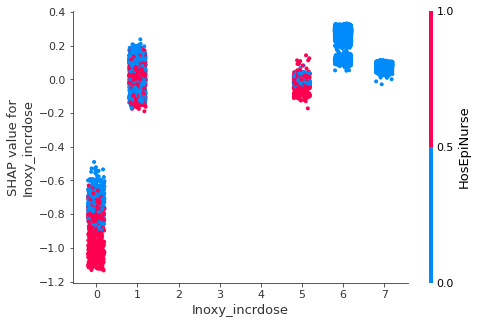

In [60]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='HosEpiNurse')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


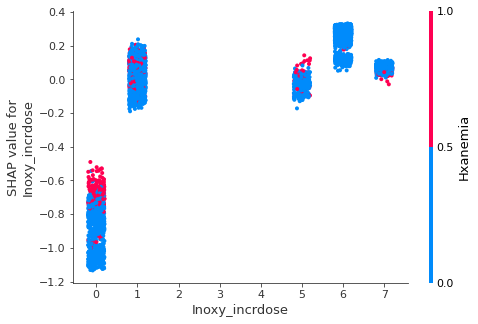

In [61]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hxanemia')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


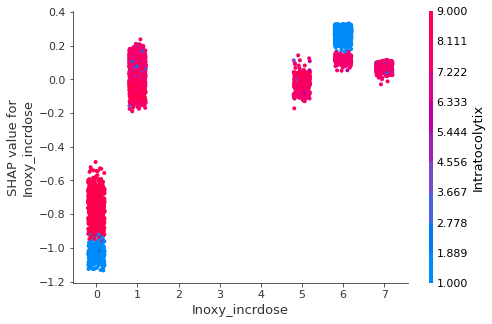

In [62]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Intratocolytix')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


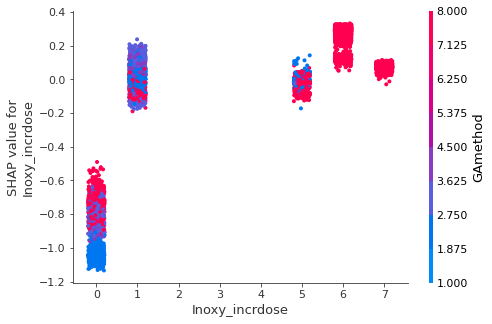

In [63]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='GAmethod')